# LBP

Se importan las librerias necesarias

In [12]:
import numpy as np
from matplotlib import pyplot as plt
import itertools
import pickle
import os
import PIL
import pandas as pd

El cálculo de cada píxel se realiza mediante la siguiente función:

In [2]:
def lbp_pixel_calc(img, x, y, r, method):
    center = img[x, y]
    matrix = img[x - r:x + r + 1, y - r:y + r + 1]
    if matrix.shape[0]*matrix.shape[1] != (r*2+1)**2:
        '''
        When there are no neighboring pixels for the given radius,
        a zero value is given to some virtual pixels outside the edges.
        '''
        img_resized = np.zeros(np.array(img.shape) + 2*r)
        img_resized[r:-r, r:-r] = img
        x += r
        y += r
        matrix = img[x - r:x + r + 1, y - r:y + r + 1]
    arr = np.concatenate((matrix[0, 1:-1][::-1], matrix[:, 0], matrix[-1, 1:-1], matrix[0:, -1][::-1]))
    arr = np.where(arr < center, 1, 0)
    if method == 'riu':
        n_arr = np.array(list(arr)*len(arr)).reshape(len(arr), -1)
        return min(np.array([roll_pattern(v, i) for i, v in enumerate(n_arr)]))
    elif method == 'riu2':
        u = len(list(itertools.groupby(np.append(arr, arr[0]), lambda bit: bit == 0))) - 1
        if u > 2:
            return r*8 + 1
        else:
            return sum(arr)
    else:
        return sum(arr * (2 ** np.arange(len(arr))[::-1]))

En ella cada se obtiene la vencidad del píxel cuyo valor LBP va a ser calculado. En caso de que dicho píxel se encentre en un borde de la imagen y no exista tal vencidad, se le proporciona valor nulo a unos píxeles virtuales que se generan para posibilitar el cálculo.

A partir de la matrix de píxeles vecinos se obtiene un vector ordenado en conforme al patrón correspondiente al algoritmo LBP:
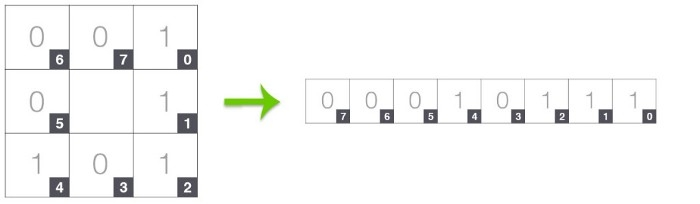
<i><center>https://medium.com/@ariesiitr/texture-analysis-using-lbp-e61e87a9056d</center></i>

Posteriorente se comparan los valores con el del píxel central, otorgando valor 1 a aquellos inferiores a este y 0 a los restantes.

1. Variante original: se calcula el equivalente decimal del número binario obtenido.
2. Variante *riu*: se calculan todos los posibles valores de conversión de binario a decimal del vector obtenido tras realizar una rotación de una posición sobre sí mismo con todas las posibles posiciones. Se selecciona el menor valor de los obtenidos. Como función auxiliar se emplea:

In [3]:
def roll_pattern(pattern, k):
    rolled = np.roll(pattern, k)
    return sum(rolled * (2 ** np.arange(len(rolled))[::-1]))

3. Variante *riu2*: en primer lugar se obtiene el número de transiciones entre valores 0 y 1 de cada dos dígitos contiguos dentro del número binario, considerando también la transición existente entre el último y primer dígito. Si este es superior a 2 se le proporciona valor equivalente al número de dígitos del número binario más una unidad. En caso contrario el valor obtenido es la suma de todos sus dígitos.

Como función principal para la ejecución del código se tiene:

In [19]:
def lbp(img, r=1, method='default', plot=False):
    height, width = img.shape
    img_lbp = np.zeros((height, width), np.uint8)
    for i in range(0, height):
        img_lbp[i, :] = [lbp_pixel_calc(img, i, j, r, method) for j in range(0, width)]
    if method == 'riu':
        if r == 1:
            # Original code:
            # __location__ = os.path.realpath(
            #     os.path.join(os.getcwd(), os.path.dirname(__file__)))
            # path = os.path.join(__location__, 'riu_r1_map.pkl')
            path = 'preprocess/riu_r1_map.pkl'
            with open(path, 'rb') as f:
                d = pickle.load(f)
        else:
            '''
            Inconsistent when comparing between different images
            '''
            d = dict(enumerate(np.unique(img_lbp)))
        img_lbp_copy = np.copy(img_lbp)
        for key, value in d.items():
            img_lbp[img_lbp_copy == value] = key
    if plot:
        plot_lbp(img, img_lbp)
    return img_lbp

La función itera sobre cada uno de los píxeles obteniendo su valor correspondiente. Para los casos en que la variante seleccionada es *riu* se mapean los distintos valores para que estos se ajusten a *0, 1, 2... n*, siendo *n* el número total de diferentes valores existentes. Este mapeo no sería consistente en la comparación entre diferentes imágenes si en una de ellas no se toman todos los posibles valores existentes, por lo que para el caso de aplicación, es decir de radio unitario, se proporciona un diccionario en el archivo *riu_r1_map.pkl* que realiza la conversión de cada uno de los posibles valores, eliminando así dicha imprecisión.

Los gráficos se generan por medio de la función:

In [5]:
def plot_lbp(img, img_lbp):
    plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(img_lbp, cmap='gray', vmax=np.max(img_lbp))
    plt.title('LBP Image')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    bins = np.arange(np.max(img_lbp)+2)-0.5
    plt.hist(img_lbp.ravel(), bins=np.arange(np.max(img_lbp)+2)-0.5, ec='white')
    plt.xlim(bins[0], bins[-1])
    plt.title('Histogram')
    plt.show()

A modo de ejemplo se parte de la imagen:

In [22]:
path = 'jupyter-media/21_training.tif'

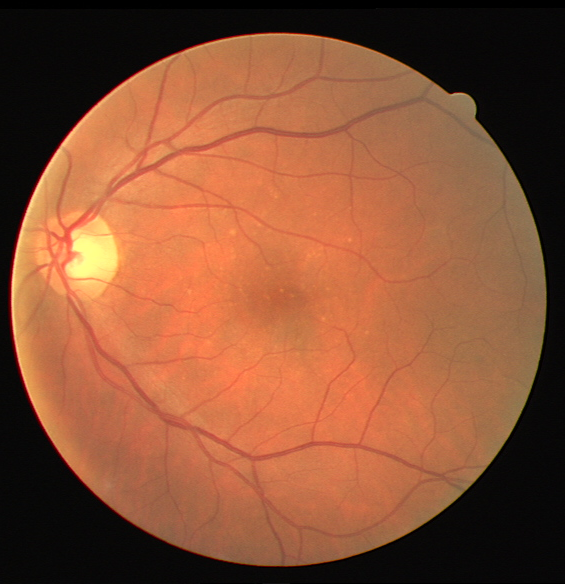

In [23]:
PIL.Image.open(path)

Que sufre la siguientes transformaciones para las distintas variantes LBP:

### Variante original

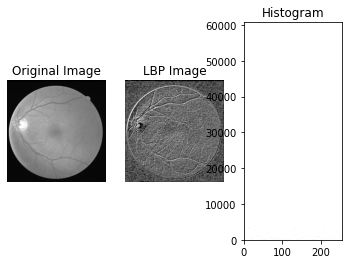

In [17]:
img = np.asarray(PIL.Image.open(path).convert('L')).copy()
lbp_img = lbp(img, r=1, method='default', plot=True)

### Variante *riu*

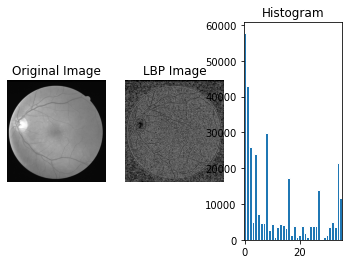

In [20]:
img = np.asarray(PIL.Image.open(path).convert('L')).copy()
lbp_img = lbp(img, r=1, method='riu', plot=True)

### Variante *riu2*

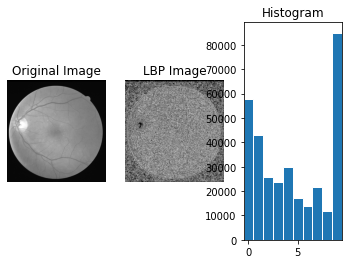

In [21]:
img = np.asarray(PIL.Image.open(path).convert('L')).copy()
lbp_img = lbp(img, r=1, method='riu2', plot=True)